# Triplet Loss

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

import matplotlib.pyplot as plt
from ipywidgets import interact

import tensorflow_addons as tfa
from tensorflow.keras.models import load_model
from tensorflow_addons.losses import TripletSemiHardLoss, TripletHardLoss

from beeid.utils import sensitivity_map

from beeid2.models import simple_cnnv2
from beeid2.data_utils import load_tf_dataset
from beeid2.viz import show_sensitivity_maps
from beeid2.evaluation import cmc_evaluation, plot_cmc
from beeid2.evaluation import get_interactive_plot_query_gallery

IMAGE_FOLDER = "/mnt/storage/work/jchan/uncensored_dataset/images/"
DATASET_CSV = "/mnt/storage/work/jchan/body_dataset2/dataset3.csv"

### Prepare dataset

Select the dates for Training, Validation and Testing datasets.

In [4]:
# def filter_dataframe(df):
#     filtered_df = df[(df.closest_bee > 300)]
#     filtered_df = filtered_df[filtered_df.abdomen_size >= 230]
#     filtered_df = filtered_df[filtered_df.abdomen_angle >= 200]
#     filtered_df = filtered_df[filtered_df.abdomen_angle <= 330]
#     filtered_df = filtered_df[filtered_df.V_mean >= 0.30]
#     return filtered_df.copy()

# df = pd.read_csv(DATASET_CSV)

# df = filter_dataframe(df)
# df= df[df.tag_id != -1.0]
# df["datetime2"] = pd.to_datetime(df["datetime"])
# df["days"] = df["datetime2"].dt.strftime("%Y-%m-%d")
# df["global_track_id"] = df["video_name"] + "_" + df["track_id"].apply(str)
# df["filename"] = IMAGE_FOLDER + df.filename

# train_df = df[df.days <= '2019-07-23']
# valid_df = df[(df.days > '2019-07-23') & (df.days < '2019-07-25')]
# test_df = df[(df.days >= '2019-08-01') & (df.days <= '2019-08-04')]
train_df=pd.read_csv("data/train_unnormalized.csv")
test_df=pd.read_csv("data/test_unnormalized.csv")
valid_df=pd.read_csv("data/valid_unnormalized.csv")

len(train_df), len(valid_df), len(test_df)

(3777, 1909, 3276)

In [5]:
train_df.filename

0       /mnt/storage/work/jchan/uncensored_dataset/ima...
1       /mnt/storage/work/jchan/uncensored_dataset/ima...
2       /mnt/storage/work/jchan/uncensored_dataset/ima...
3       /mnt/storage/work/jchan/uncensored_dataset/ima...
4       /mnt/storage/work/jchan/uncensored_dataset/ima...
                              ...                        
3772    /mnt/storage/work/jchan/uncensored_dataset/ima...
3773    /mnt/storage/work/jchan/uncensored_dataset/ima...
3774    /mnt/storage/work/jchan/uncensored_dataset/ima...
3775    /mnt/storage/work/jchan/uncensored_dataset/ima...
3776    /mnt/storage/work/jchan/uncensored_dataset/ima...
Name: filename, Length: 3777, dtype: object

### Tensorflow Dataset

In [6]:
train_dataset = load_tf_dataset(train_df, rescale_factor=4, augmentation=False).shuffle(len(train_df))
valid_dataset = load_tf_dataset(valid_df, rescale_factor=4)

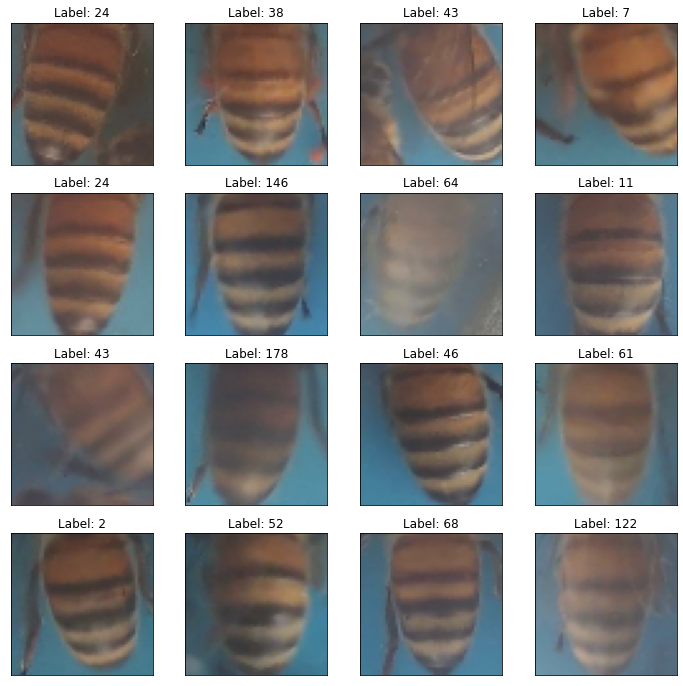

In [7]:
data = train_dataset.batch(32)
gen = iter(data)
sample_batch = next(gen)

EXAMPLES=2

fig, ax = plt.subplots(4, 4, figsize=(12, 12))
ax = ax.ravel()
for j in range(16):
    ax[j].imshow(sample_batch[0][j])
    ax[j].set_title("Label: {}".format(sample_batch[1][j].numpy()))
    ax[j].set_xticks([])
    ax[j].set_yticks([])

### Model

In [8]:
model = simple_cnnv2(input_shape=(56, 56, 3), conv_blocks=3, latent_dim=128)

In [6]:
# model.load_weights("weights/pretraining_triplet_loss.tf")
# model.load_weights("weights/triplet_loss_unnormalized_no_augmentation.h5")

In [9]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
    loss=TripletSemiHardLoss(margin=0.2))

In [10]:
# Train the network
BATCH_SIZE=256
EPOCHS=1000
PATIENCE=100


earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history = model.fit(train_dataset.batch(BATCH_SIZE), validation_data=valid_dataset.batch(BATCH_SIZE), epochs=EPOCHS, callbacks=[earlystop])

Epoch 1/1000
15/15 [==============================] - 7s 496ms/step - loss: 0.1795 - val_loss: 0.1742
Epoch 2/1000
15/15 [==============================] - 2s 164ms/step - loss: 0.1548 - val_loss: 0.1824
Epoch 3/1000
15/15 [==============================] - 2s 164ms/step - loss: 0.1409 - val_loss: 0.1881
Epoch 4/1000
15/15 [==============================] - 2s 166ms/step - loss: 0.1325 - val_loss: 0.1822
Epoch 5/1000
15/15 [==============================] - 3s 170ms/step - loss: 0.1197 - val_loss: 0.1762
Epoch 6/1000
15/15 [==============================] - 2s 164ms/step - loss: 0.1132 - val_loss: 0.1748
Epoch 7/1000
15/15 [==============================] - 2s 163ms/step - loss: 0.1031 - val_loss: 0.1848
Epoch 8/1000
15/15 [==============================] - 2s 165ms/step - loss: 0.0975 - val_loss: 0.1790
Epoch 9/1000
15/15 [==============================] - 2s 163ms/step - loss: 0.0881 - val_loss: 0.1699
Epoch 10/1000
15/15 [==============================] - 3s 167ms/step - loss: 0.085

In [9]:
model.save("models/triplet_loss_unnormalized_no_augmentation.h5")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/triplet_loss_pretrained_no_augmentation.tf/assets


### Checking Training

<AxesSubplot:>

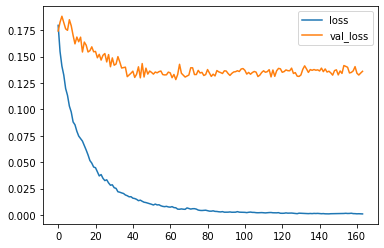

In [11]:
pd.DataFrame(history.history).plot()

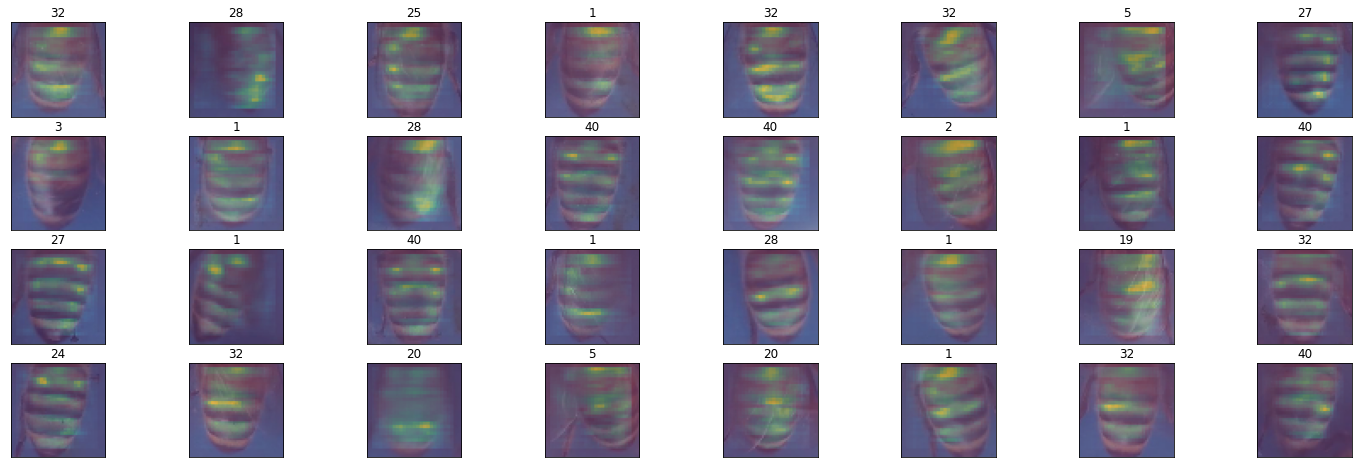

In [11]:
show_sensitivity_maps(model, valid_dataset)

## Evaluation

In [12]:
ITERATIONS=100
GALLERY_SIZE=10

### Evaluation only ids shared with the training set (validation set)

100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


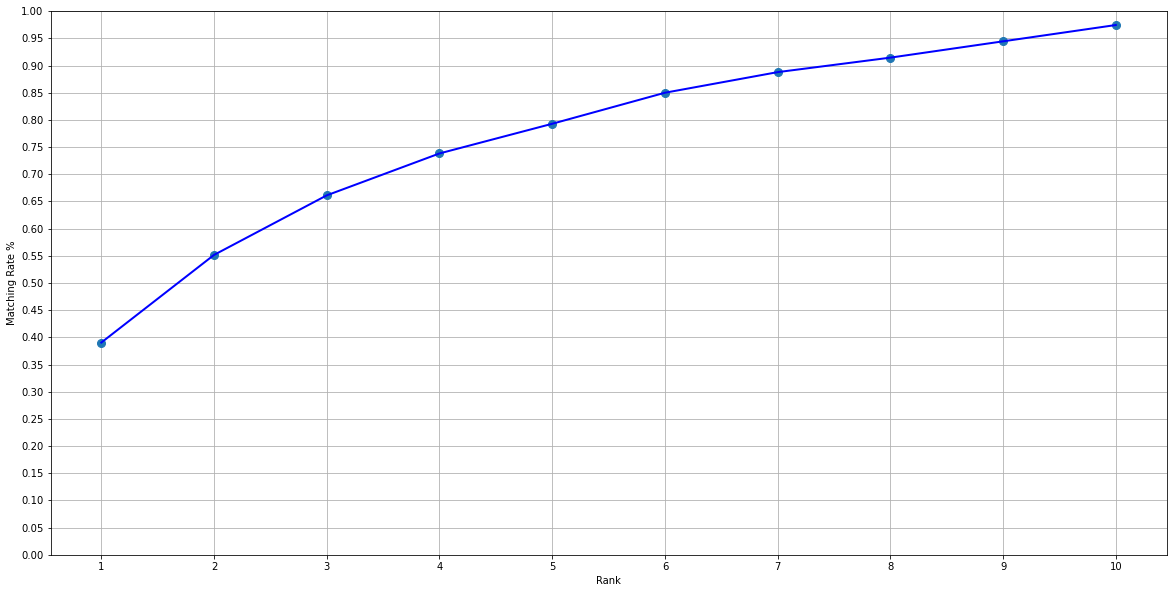

In [13]:
train_ids = train_df.track_tag_id.unique()

valid_with_shared_ids = valid_df[valid_df.track_tag_id.isin(train_ids)]

valid_with_shared_ids_ranks_means = cmc_evaluation(model, valid_with_shared_ids, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(valid_with_shared_ids_ranks_means )

### Evaluation on the whole validation set

100%|██████████| 100/100 [03:15<00:00,  1.95s/it]


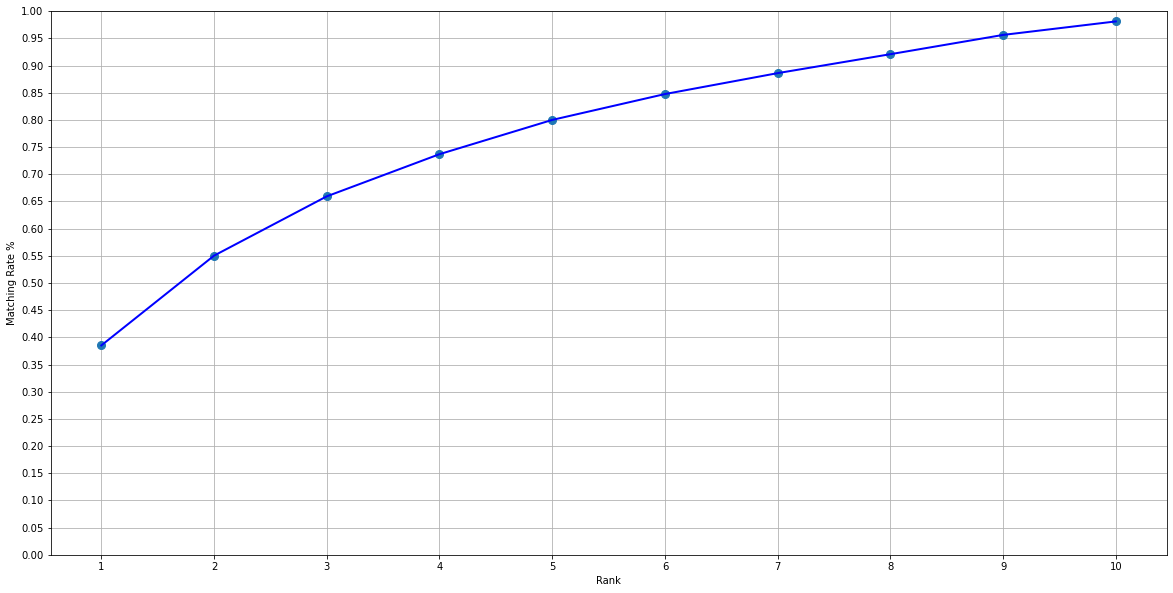

In [14]:
valid_ranks_means = cmc_evaluation(model, valid_df, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(valid_ranks_means)

### Evaluation on whole test set

100%|██████████| 100/100 [11:45<00:00,  7.05s/it]


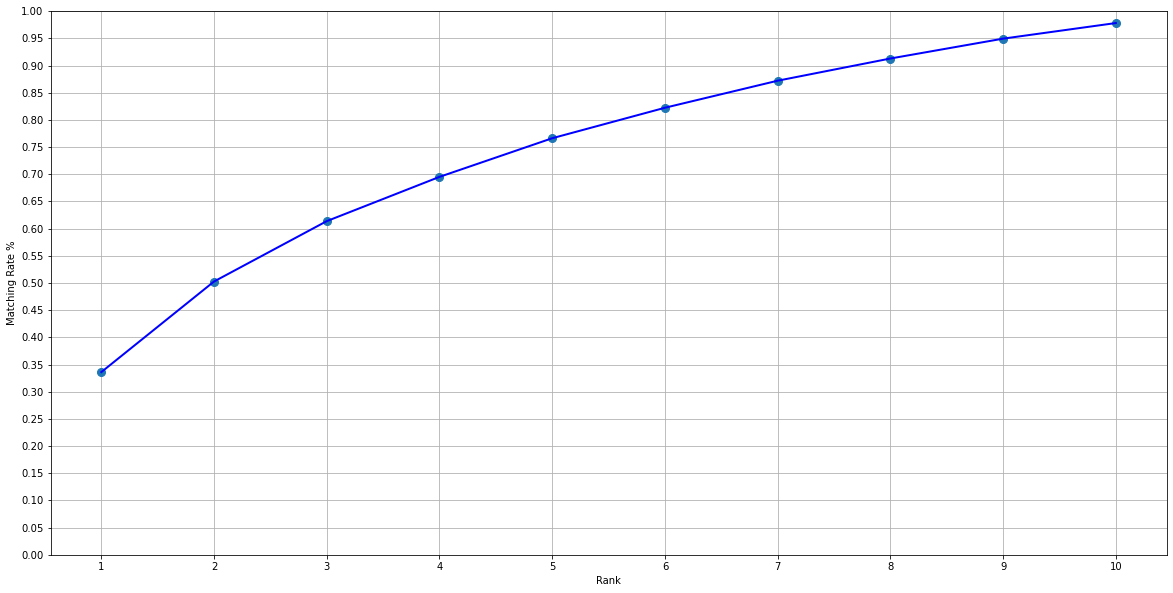

In [15]:
test_ranks_means = cmc_evaluation(model, test_df, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(test_ranks_means)

In [16]:
train_ids = train_df.track_tag_id.unique()
test_ids = test_df.track_tag_id.unique()


intersection = set(train_ids) & set(test_ids)

print("Test set has {} Ids.".format(len(test_ids)))
print("Intersection of train and test set {}".format(len(intersection)))

Test set has 126 Ids.
Intersection of train and test set 29


100%|██████████| 100/100 [07:23<00:00,  4.43s/it]


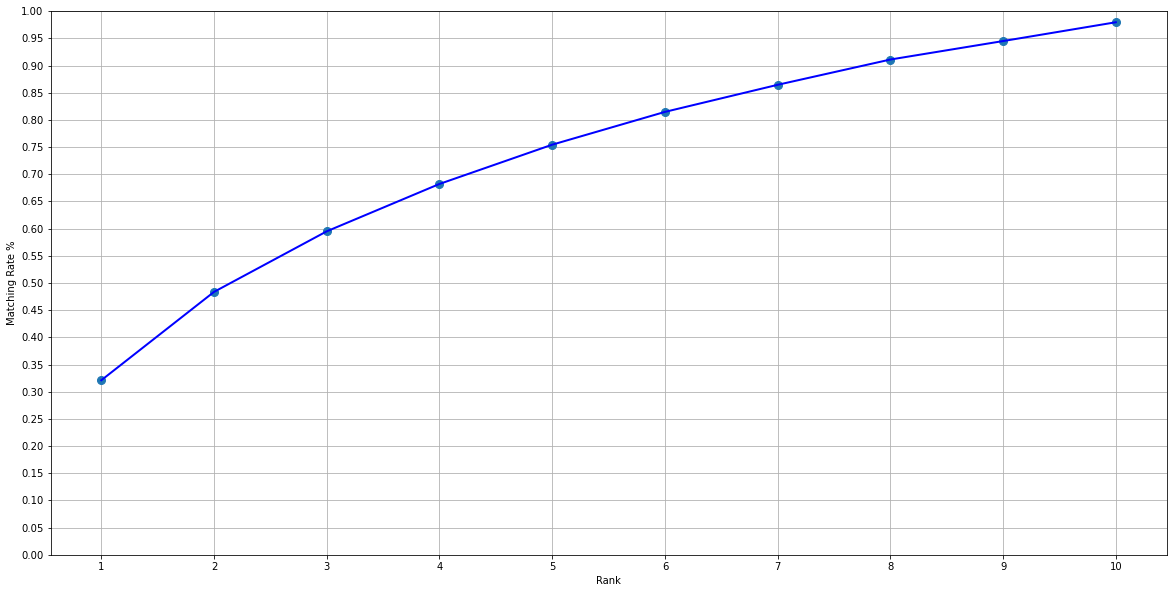

In [17]:
test_disjoint_train = test_df[~test_df.track_tag_id.isin(train_ids)]

test_disjoint_train_ranks_means = cmc_evaluation(model, test_disjoint_train, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(test_disjoint_train_ranks_means)

#### Saving results

In [18]:
metric_dict = dict()

metric_dict["valid_cmc_only_train_ids"] = valid_with_shared_ids_ranks_means 
metric_dict["valid_cmc"] = valid_ranks_means
metric_dict["test_cmc"] = test_ranks_means
metric_dict["test_cmc_no_ids_overlap"] = test_disjoint_train_ranks_means

metric_df = pd.DataFrame(metric_dict)
metric_df.to_csv("results/triplet_loss_no_augmenatation.csv")

#### Interactive Query Plotting

In [17]:
get_interactive_plot_query_gallery(model, valid_df)

interactive(children=(IntSlider(value=17, description='query_id', max=34), Checkbox(value=False, description='…